# The Simplified Resonate-and-Fire Neuron: Part I

### Tutorial by Giorgie I. Goiati
Special thanks to Corentin Houpert for the maths help

# Introduction
In this tutorial, you will:
* Learn the fundamentals of the resonate-and-fire (RF) neuron model
* Study the dynamics of the RF neuron model and how it differs from the LIF model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from plotter import snn_plot, plot_phase_portrait

In [2]:
# Simulation constants
NUM_STEPS = 1000
DT = 0.01

# 1. Integrators vs. Resonators Neuron Models


By now you should be fairly familiar with the **Leaky Integrate-and-Fire (LIF)** neuron model, which integrates the weighted inputs over time and emits a spike when the integrated value exceeds a threshold.  
Neurons akin to the LIF model are accordingly referred to as **integrator** neurons, but these only constitute one of two major modes of neuronal spiking behaviour.
<!-- The LIF neuron is a simple yet powerful model that captures neuronal excitability and spiking behavior, but it only corresponds to a the behaviour of **integrator** neurons. -->

In contrast, damped or sustained subthreshold oscillations of membrane potential can be observed in many biological neurons, which can be classified as **resonator** neurons.
These neurons may share many of the same properties as integrator neurons, but critically exhibit damped *oscillatory* convergence of the membrane potential to the resting state instead of of exponential convergence, which results in signficicantly different neurocomputational properties:

<!-- !TODO: table comparing integrators vs. resontators -->
| Property | Integrator Neurons | Resonator Neurons |
|----------|---------------------|-------------------|
| Subthreshold oscillations | No | Yes |
| Threshold | Mainly fixed | Phase-sensitive |
| Relation input amplitude  spike generation | Continuous | Discontinuous |
| Inhibitory spikes | Impedes/delays spiking | Can promote spiking |
| Preferred input | Sustained, at a high rate | At resonant frequency |
| First vs. second spike timing | First delayed, then regular spiking | First fast (if resonant), then depends on phase |


<!-- <center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_1_neuronmodels.png?raw=true' width="1000">
</center> -->

Expanding on LIF neurons, the **Resonate-and-Fire (RF)** neuron model is the simplest model to exhibit the most important features of resonators: damped oscillations, frequency preference, postinhibitory (rebound) spikes, and spikes generated relative to the frequency of the input signal (as opposed to the strength of the input signal).

[Dynamical Systems in Neuroscience (Izhikevich, Eugene M., 1967)](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://www.izhikevich.org/publications/dsn.pdf&ved=2ahUKEwjt3s7E9cWNAxUSWEEAHXlnM3QQFnoECBYQAQ&usg=AOvVaw2fyirRlvNchh6lSoFqul60)

# 2. Izhikevich's Resonate-and-Fire Neuron Model

## 2.1 Resonator Neurons: Definitions


[Eugene M. Izhekevich in 2001](https://www.izhikevich.org/publications/resfire.pdf) introduced the resonate-and-fire (RF) neuron with its dynamics as a complex-valued, first-order linear ordinary differential equation (ODE):

$$ \frac{dU(t)}{dt} = (- b + i\omega)U(t) + I(t) \tag{1}$$

Here $b > 0$ is the damping coefficient, $\omega$ is the oscillation frequency, $I(t)$ is the input current, and $U(t) = (x + iy) \in \mathbb{C}$ is the membrane potential of the neuron.

Say the neuron starts at some value $U(0)$ with no input current, then the solution to the differential equation (1) is:
$$ U(t) = U(0) e^{(-b + i\omega)t} = U(0) e^{-b t} e^{i \omega t} \tag{2}$$

### Comparison to the LIF definition
Equation (1) was formulated to diverge as little as possible from the established LIF neuron, so it's worth to compare the two.  
Let's recall the LIF neuron (with $C=1$ and $\tau = RC$):

$$ \begin{align*}
\frac{dU(t)}{dt} &= -\frac{1}{\tau}U(t) + I(t) \\
U(t) &= U(0) e^{-\frac{t}{\tau}}, \quad \text{given } I(t) = 0
\end{align*} \tag{LIF}$$

$e^{-\frac{t}{\tau}}$ describes the exponential decay of the membrane potential over time, where $\tau$ is the time constant of the neuron.  
For the RF neuron in equation (2), its behaviour is described through an equivalent exponential decay $e^{-bt}$ multipled with an oscillatory component $e^{i \omega t}$.
As such, write the damping coefficient $b$ in terms of the time constant $\tau$:
$$ \begin{align*}
b = \frac{1}{\tau} &\iff \tau = \frac{1}{b} \tag{3}\\
\implies \frac{dU(t)}{dt} &= (-\frac{1}{\tau} + i\omega)U(t) + I(t) \\
% U(t) &= U(0) e^{-\frac{t}{\tau}} e^{i \omega t}, \quad \text{given } I(t) = 0
\end{align*}$$
Though given its prevalence in literature on resonating neurons, we'll stick to the damping coefficient $b$ for now.

### Forward Euler Method to Solving the LIF Neuron Model

To simulate the RF neuron and for use in neural networks, we can use the forward Euler method to solve the previous linear ODE and obtain a discrete-time representation of the neuron model:

$$ \frac{dU(t)}{dt} \approx \frac{U(t + \Delta t) - U(t)}{\Delta t}$$

where $\Delta t$ is the time step size. Substituting this into the ODE gives:

$$\frac{dU(t + \Delta t) - U(t)}{\Delta t} = (- b + i\omega)U(t) + I(t)$$

For a small enough $\Delta t$, this gives a *decent** approximation of continuous-time integration. Isolating the membrane at the following time step gives:

$$ \begin{align*}
U(t + \Delta t) &= U(t) + \Delta t ( (- b + i\omega)U(t) + I(t)) \\
    &= (1 - \Delta t (b - i\omega))U(t) + \Delta t I(t) \\
\end{align*} \tag{4}$$

> \* We will stick with this formulation for this tutorial, but it should be noted that the forward Euler method is a poor fit for oscillatory systems. While sufficient for LIF neurons, the numerical error accumulates more quickly and significantly in RF neurons, leading to unstable oscillations.  
> In the next tutorial, we will introduce a more accurate formulation that addresses this.

## 2.2 Izhikevich: Without Stimulus

Let's simulate the Izhikevich neuron model we defined above without any external input current to get started.

With default values of $\omega = 10$ rad/s, $b = 1 s^{-1}, and $U(0)=0.9+0i V$, we can take a closer look at how the Euler approximation (4) diverges from the exact solution (2), and moreover showcase how RF neurons are nothing more than LIF neurons with some added oscillation.
For the simulations below, we have chosen $\Delta t = 1 \times 10^{-2} s$. This still introduces some numerical error, but it gets the point across.

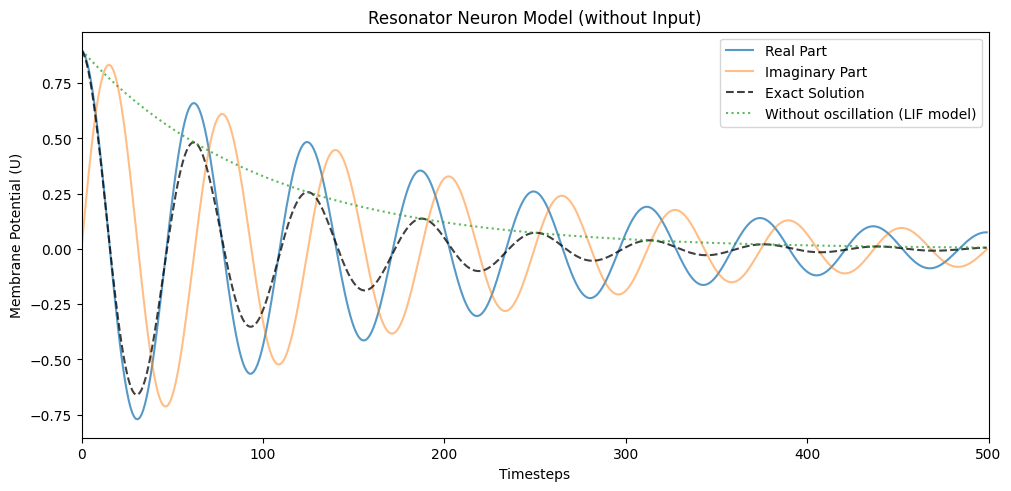

In [3]:
u, u_exact, u_lif = 0.9+0j, 0.9+0j, 0.9+0j
u_rec, u_exact_rec, u_lif_rec = [], [], []
b, omega = 1, 10

for step in range(NUM_STEPS//2):
    u_rec.append(u)
    u = u + DT * ((-b + 1j * omega) * u)  # forward Euler method
    u_exact_rec.append(u_exact)
    u_exact = u_exact * np.exp((-b + 1j * omega) * DT)  # exact solution
    u_lif_rec.append(u_lif)
    u_lif = u_lif + DT * ((-b + 1j * 0) * u_lif) # with omega=0

fig = plt.figure(figsize=(10, 4.8), layout='constrained')
plt.title("Resonator Neuron Model (without Input)")
plt.plot(np.real(u_rec), label="Real Part", c='tab:blue', alpha=0.75)
plt.plot(np.imag(u_rec), label="Imaginary Part", c='tab:orange', alpha=0.5)
plt.plot(np.real(u_exact_rec), label="Exact Solution", linestyle='--', c='black', alpha=0.75)
plt.plot(np.real(u_lif_rec), label="Without oscillation (LIF model)", c='tab:green', linestyle=':', alpha=0.75)
plt.xlabel("Timesteps")
plt.ylabel("Membrane Potential (U)")
plt.xlim([0, NUM_STEPS//2])
plt.legend()
plt.show()

## 2.2 Izhikevich: With Stimulus

Let's run some simulations of the RF neuron with different types of input current to get a better understanding of its dynamics.

### Step Input
Apply a step current $I_{\rm in}(t)$ that switches on at $t = t_0$ and stays constant.

When a sustained step input is applied to the RF neuron, the *imaginary* 'rest state' of the neuron is shifted to a new value, which is determined by the input current: 
$$U(0_{\rm new}) = \frac{I_{\rm in}(t_0)}{b-i\omega} \tag{5}$$

**Optional: Derivation of the RF Neuron Model for Constant Input**
***
Recall the linear first-order ODE of the RF neuron from equation (4) and its solution for the homogeneous part:
$$\begin{align*} 
\frac{dU(t)}{dt} &= (-b + i\omega)U(t) + I_{\rm in}(t)\\
U(t) &= U(0) e^{(-b + i\omega)t}, \quad \text{given } I_{\rm in}(t) = 0
\end{align*}$$

To derive the general solution to the RF neuron with a (constant) input current at $t_0$ we first apply the method of variation of constants:

$$\begin{align*}
U(t)    &= C(t) e^{(-b + i\omega)t} \\
\implies \frac{dU(t)}{dt} &= C'(t) e^{(-b + i\omega)t} + (-b + i\omega)C(t)e^{(-b + i\omega)t} \\
        &= C'(t)e^{(-b + i\omega)t} + (-b + i\omega)U(t) \\
        &= C'(t) e^{(-b + i\omega)t} + \frac{dU(t)}{dt} - I_{\rm in}(t_0) \\
C'(t) e^{(-b + i\omega)t} &= I_{\rm in}(t_0) \\
C'(t)   &= I_{\rm in}(t_0) e^{-(-b + i\omega)t} = I_{\rm in}(t_0) e^{(b - i\omega)t} \\
\end{align*}$$
Integrating both sides with respect to $t$ gives:
$$\begin{align*}
C(t)    &= I_{\rm in}(t_0) \int_{t_0}^{t} e^{(b - i\omega)s}ds \\
        &= I_{\rm in}(t_0) \left[ \frac{e^{(b - i\omega)s}}{b - i\omega} \right]_{t_0}^{t} \\
        &= \frac{I_{\rm in}(t_0)}{b - i\omega} \left( e^{(b - i\omega)t} - e^{(b - i\omega)t_0} \right) \\
\end{align*}
$$

Given the solution for $C(t)$, we can now write the general solution and recover (5):

$$\begin{align*}
U(t)    &= C(t) e^{(-b + i\omega)t} \\
        &= \frac{I_{\rm in}(t_0)}{b - i\omega} \left( e^{(b - i\omega)t} - e^{(b - i\omega)t_0} \right) e^{(-b + i\omega)t} \\
        &= \frac{I_{\rm in}(t_0)}{b - i\omega} \left( 1 - e^{(b - i\omega)(t_0 - t)} \right) \\
        &= \frac{I_{\rm in}(t_0)}{b - i\omega} \left( 1 - 0i \right) = \frac{I_{\rm in}(t_0)}{b - i\omega}, \quad \text{given } t \to \infty \tag{5}
\end{align*}$$ 
***

In [4]:
def resonate_neuron(u, b=1, omega=10, dt=DT, I=0):
    return u + dt * ((-b + 1j * omega) * u + I)

def resonate_neuron_exact(u, b=1, omega=10, dt=DT, I=0):
    return u * np.exp((-b + 1j * omega) * dt) + I * dt

Final membrane potential: 0.05+0.50j
Derived new resting state: I(t_0)/(b - iω) = 0.05+0.50j


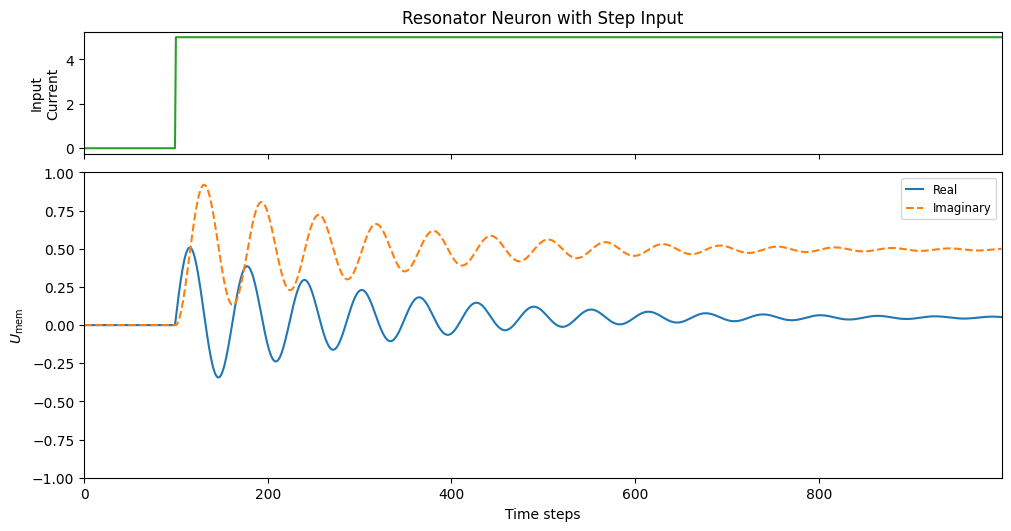

In [5]:
def new_resting_state(I, b=1, omega=10):
	return I / (b - 1j * omega)

t0 = 100  # time step at which input current turns on
cur_in = np.zeros(NUM_STEPS)
amp_in = 5  # amplitude of input
cur_in[t0:] = amp_in  # input current turns on at t=1s
mem1 = (0 + 0j)
mem_rec1 = []

for step in range(NUM_STEPS):
	mem1 = resonate_neuron(mem1, I=cur_in[step])
	mem_rec1.append(mem1)

print(f"Final membrane potential: {mem_rec1[-1]:.2f}")
print(f"Derived new resting state: I(t_0)/(b - iω) = {new_resting_state(amp_in):.2f}")
snn_plot(cur_in=cur_in, mem=mem_rec1, title="Resonator Neuron with Step Input", ylim=1, vline=t0)

### Pulse Input
Apply and compare three pulse currents $I_{\rm in}(t)$ that switch on at $t = t_0 (= 100)$, with different durations and amplitudes.  

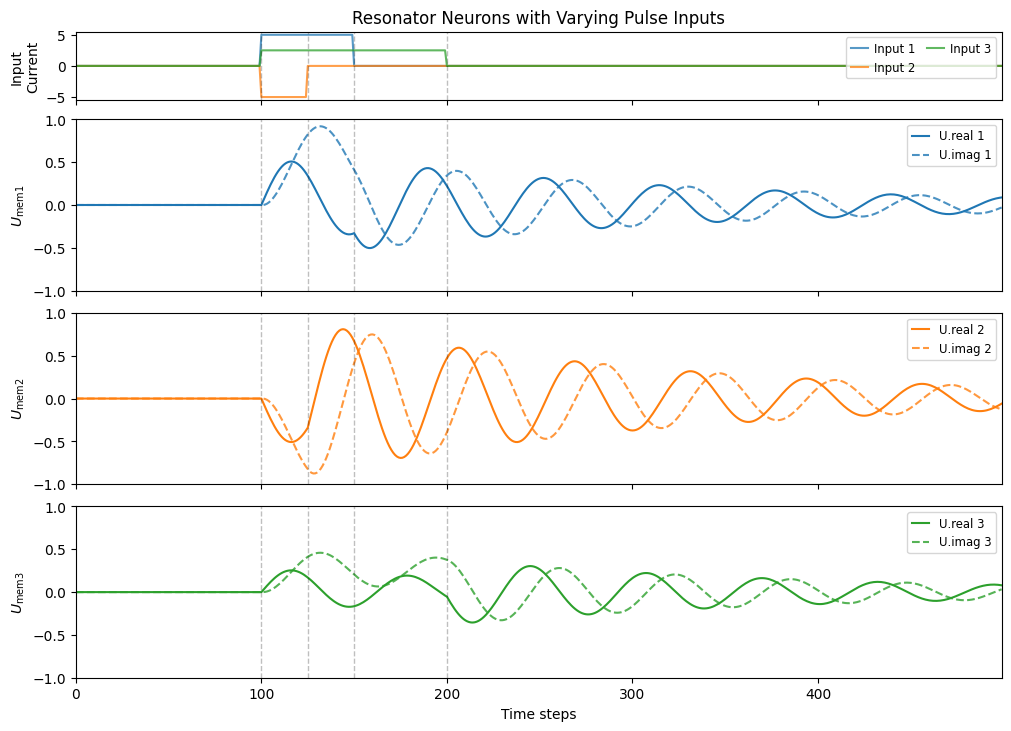

In [6]:
num_steps = NUM_STEPS // 2
t0,t1,t2,t3 = 100, 150, 125, 200
i1,i2,i3 = 5, -5, 2.5
cur1, cur2, cur3 = np.zeros(num_steps), np.zeros(num_steps), np.zeros(num_steps)
cur1[t0:t1] = i1  # input current turns on at t=1s and turns off at t=2s
cur2[t0:t2] = i2  # input current turns on at t=2s and turns off at t=3s
cur3[t0:t3] = i3  # input current turns on at t=3s and turns off at t=4s
mem1, mem2, mem3 = (0 + 0j), (0 + 0j), (0 + 0j)
mem_rec1, mem_rec2, mem_rec3 = [], [], []

for step in range(num_steps):
    mem_rec1.append(mem1), mem_rec2.append(mem2), mem_rec3.append(mem3)
    mem1 = resonate_neuron(mem1, I=cur1[step])
    mem2 = resonate_neuron(mem2, I=cur2[step])
    mem3 = resonate_neuron(mem3, I=cur3[step])

snn_plot(cur_in=[cur1, cur2, cur3], mem=[mem_rec1, mem_rec2, mem_rec3], 
        title="Resonator Neurons with Varying Pulse Inputs", 
        ylim=1, vline=[t0, t1, t2, t3])

### Spike Input
More interesting and important for resonating neurons is what happens when (non-)resonant input is applied.  
Let's generate a train of spikes with a specific frequency as input for two RF neurons with different $\omega$ and compare their responses.

In [7]:
def generate_resonant_spikes(
        num_steps: int = NUM_STEPS,
        first_spike: int = None,
        dt: float = DT, 
        omega: float | int = 10, 
        n_spikes: int = 4,
        amplitude: int = 1, 
        add_neg_spike: bool = True, 
    ) -> np.ndarray:
    out = np.zeros(num_steps)
    if first_spike is None:
        first_spike = int(num_steps // 10)
    period = int(np.round((2 * np.pi) / omega / dt))
    end = first_spike + period * n_spikes
    if end > num_steps:
        end = num_steps
    for i in range(first_spike, end, period):
        out[i] = amplitude
    if add_neg_spike:
        out[i-period//2] = -amplitude
    return out

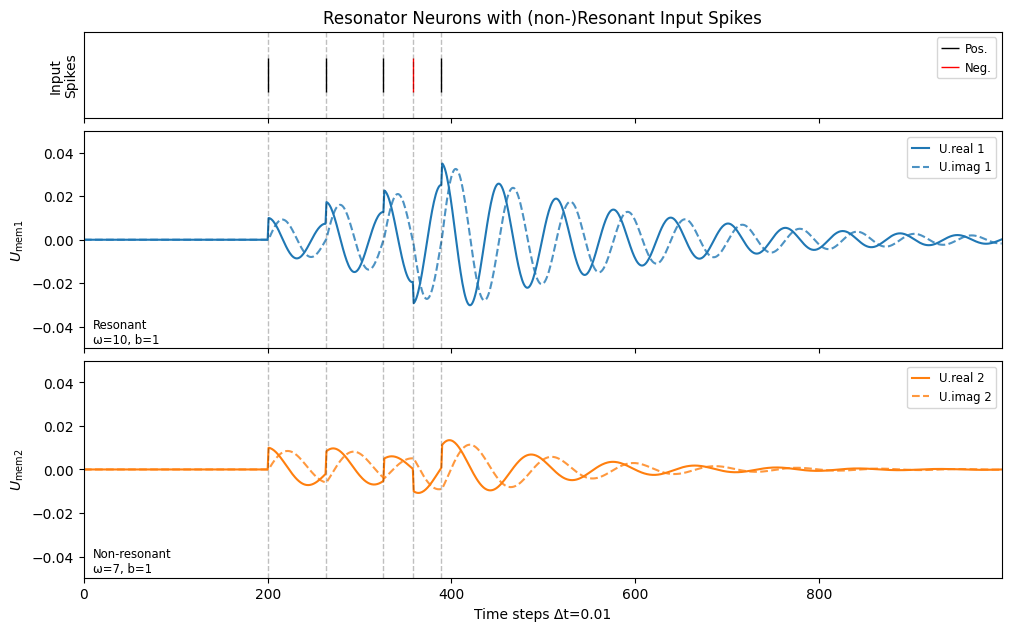

In [8]:
spk_amp = 1
spk_in = generate_resonant_spikes(NUM_STEPS, first_spike=200, omega=10., amplitude=spk_amp)
mem1, mem2 = (0 + 0j), (0 + 0j)
mem_rec1, mem_rec2 = [], []

for step in range(NUM_STEPS):
    mem_rec1.append(mem1), mem_rec2.append(mem2)
    mem1 = resonate_neuron(mem1, I=spk_in[step], omega=10.)
    mem2 = resonate_neuron(mem2, I=spk_in[step], omega=7.)

snn_plot(spk_in=spk_in, mem=[mem_rec1, mem_rec2], dt=DT,
    mem_labels=[f"Resonant\nω=10, b=1",f"Non-resonant\nω=7, b=1"],
    title="Resonator Neurons with (non-)Resonant Input Spikes",
    ylim=(.5*spk_amp / (np.sqrt(1**2 + 10**2))), # approx. max membrane potential given I, ω, b
    vline=spk_in.nonzero()[0])

### Oscillatory Input
Finally, we should also take a look at the response of the RF neuron to oscillatory input currents, the most relevant input type for resonating neurons.  
We generate a sine wave as input for a few RF neurons with different $\omega$ and $b$ and compare their responses.

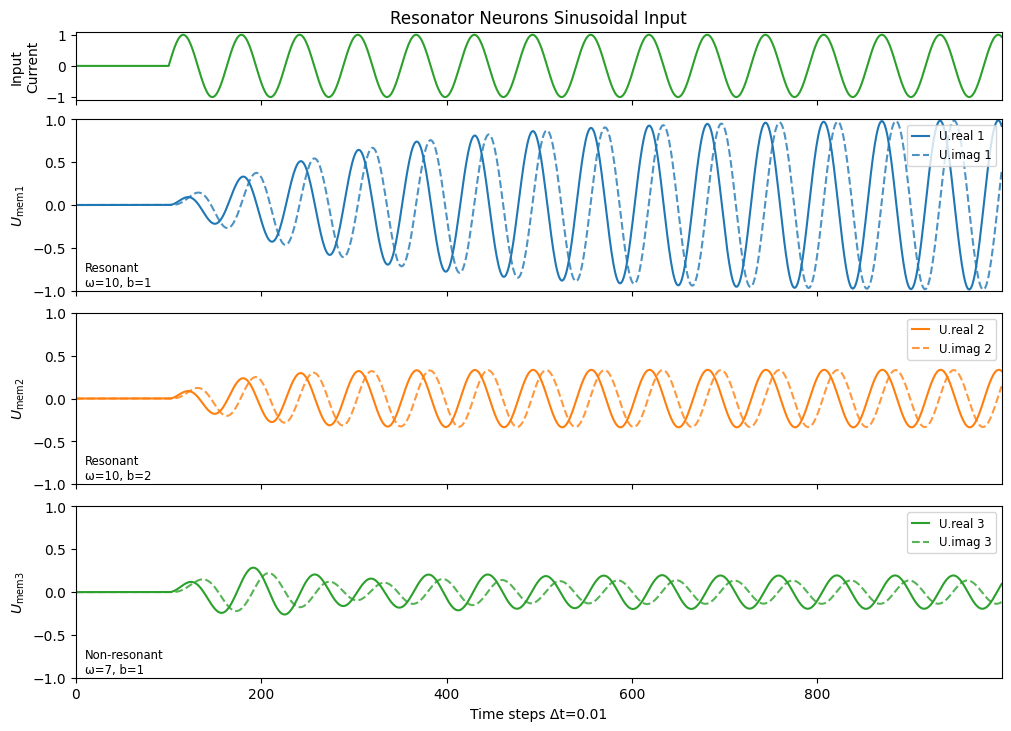

In [9]:
amp_in, omega_in, omega_rf, b = 1, 10, 10, 1
cur_sin = np.zeros(NUM_STEPS)
cur_sin[100:] = amp_in * np.sin(omega_in * DT * (np.arange(NUM_STEPS)[100:] - 100))
mem1, mem2, mem3 = (0 + 0j), (0 + 0j), (0 + 0j)
mem_rec1, mem_rec2, mem_rec3 = [], [], []

for step in range(NUM_STEPS):
    mem_rec1.append(mem1), mem_rec2.append(mem2), mem_rec3.append(mem3)
    mem1 = resonate_neuron(mem1, b=b, omega=omega_rf, I=cur_sin[step])
    mem2 = resonate_neuron(mem2, b=b+1, omega=omega_rf, I=cur_sin[step])
    mem3 = resonate_neuron(mem3, b=b, omega=omega_rf-3, I=cur_sin[step])

snn_plot(cur_in=cur_sin, mem=[mem_rec1, mem_rec2, mem_rec3], dt=DT,
    mem_labels=[f"Resonant\nω={omega_rf}, b={b}", f"Resonant\nω={omega_rf}, b={b+1}", f"Non-resonant\nω={omega_rf-3}, b={b}"],
    title="Resonator Neurons Sinusoidal Input", ylim=1)

Notice how the membrane potential of neurons in resonance with the input frequency start matching the input oscillations, with the amplitude of the oscillations being determined by the damping coefficient $b$.
On the other hand, non-resonant neurons end up oscillating at the input frequency, but with a much lower amplitude and with a phase shift.

> **The maximum sustainable amplitude of an RF neuron is achieved when the input is a resonant sinusoid.**

We can derive this maximum amplitude of a driven RF neuron. This is useful for setting model parameters, which we will get to in the next tutorial.  

The resulting amplitude $A_{\rm res}$ of a driven RF neuron, for an input $I_{\rm in}(t) = A_{\rm in} \cos(\omega_{\rm in} t)$ and the neuron's $\omega_0$ and $b$ parameters, is given by:
$$A_{\rm res} = \frac{A_{\rm in} \sqrt{b^2 + \omega_{\rm in}^2}}{\sqrt{(-\omega_{\rm in}^2 + \omega_0^2 + b^2)^2 + 4b^2\omega_{\rm in}^2}} \tag{6} $$

Naturally, the maximum amplitude $A_{\rm max}$ is achieved when the input frequency matches the neuron's resonant frequency $\omega_{\rm in} = \omega_0$, which allows us to simplify the equation:
$$A_{\rm max} = \frac{A_{\rm in} \sqrt{b^2 + \omega^2}}{b\sqrt{b^2 + 4\omega^2}} \tag{7}$$

Let's test the equation for the neurons we just simulated:

In [10]:
# Calculate the response membrane potential for each neuron in the previous plot
def amp_res(amp_in, b, omega_in, omega_rf):
    numerator = amp_in * np.sqrt(b**2 + omega_in**2)
    denominator = np.sqrt((-omega_in**2 + omega_rf**2 + b**2)**2 + 4*b**2*omega_in**2)
    return numerator / denominator

print(f"Max (real) membrane potential of each neuron above, *after stabilizing*:") # NUM_STEPS//2 is plenty to stabilize
print(f"{np.max(mem_rec1[NUM_STEPS//2:]).real:.2f}, {np.max(mem_rec2[NUM_STEPS//2:]).real:.2f}, {np.max(mem_rec3[NUM_STEPS//2:]).real:.2f}")

print(f"Derived response membrane potential of each neuron above:")
print(f"{amp_res(amp_in, b, omega_in, omega_rf):.2f}, {amp_res(amp_in, b+1, omega_in, omega_rf):.2f}, {amp_res(amp_in, b, omega_in, omega_rf-3):.2f}")

Max (real) membrane potential of each neuron above, *after stabilizing*:
0.99, 0.34, 0.20
Derived response membrane potential of each neuron above:
0.50, 0.25, 0.19


Well, that's quite some discrepancy. What's going on?

The discretization error of Euler's forward method is starting to show, as even with an, on paper, small enough timestep size, the numerical error accumulates and leads to inaccurate results.  
To confirm this, we can do a quick run of the exact RF neuron model and see the results match up.

In [11]:
mem_rec1, mem_rec2, mem_rec3 = [(0 + 0j)], [(0 + 0j)], [(0 + 0j)]
for step in range(NUM_STEPS):
    mem_rec1.append(resonate_neuron_exact(mem_rec1[step], b=b, omega=omega_rf, I=cur_sin[step]))
    mem_rec2.append(resonate_neuron_exact(mem_rec2[step], b=b+1, omega=omega_rf, I=cur_sin[step]))
    mem_rec3.append(resonate_neuron_exact(mem_rec3[step], b=b, omega=omega_rf-3, I=cur_sin[step]))
print(f"Max (real) membrane potential of each exact neuron, *after stabilizing*:")
print(f"{np.max(mem_rec1[NUM_STEPS//2:]).real:.2f}, {np.max(mem_rec2[NUM_STEPS//2:]).real:.2f}, {np.max(mem_rec3[NUM_STEPS//2:]).real:.2f}")

Max (real) membrane potential of each exact neuron, *after stabilizing*:
0.51, 0.26, 0.19


It may be possible to estimate the numerical error to some extent, but these fall short too, which is why the more exact formulation is used in the next tutorial and moving forward.

**Optional: Derivation of the Maximum Sustainable Amplitude $A_{\rm max}$ of the RF Neuron Model**

---
What we're ultimately interested in here is the amplitude of either the real or imaginary part of the RF neuron model's response (they'll both be the same).  
So let's first rewrite the complex-valued ODE (1) in terms of its real and imaginary parts, i.e. $U(t) = x(t) + i y(t)$ (we will leave out `(t)` for brevity):

$$\begin{align*}
\frac{dU}{dt} &= (-b + i \omega) U + I, \quad I \in \mathbb{R} \\
\frac{d[x + i y]}{dt} &= (-b + i \omega) (x + i y) + I \\
x' + i y' &= -b x + i \omega x - i b y + i^2 \omega y + I \\
&= -b x - \omega y + I + i (\omega x - b y)
\end{align*}$$

Separating real and imaginary parts, we obtain:
$$\begin{cases}
x' &= -b x - \omega y + I \quad\text{(real)} \\
y' &= \omega x - b y \quad\text{(imaginary)}
\end{cases} \tag{a}$$

---
Now, let's stick to the real part $x$.
For the maximum sustainable amplitude of a driven RF neuron model, we need to figure out when *the rate of change of the rate of change* equals zero, i.e., the 2nd-order ODE.  
Deriving the second-order ODE for the real part with respect to $t$ (consider $I$ changes with time as well):
$$\begin{align*}
x'' &= -b x' - \omega y' + I' \\
&= -b x' - \omega (\omega x - b y) + I' \\
&= -b x' - \omega^2 x + b \omega y + I' \tag{b}
\end{align*}$$
From (a) we have:
$$\begin{align*}
x' &= -b x - \omega y + I \\
y &= \frac{-b x - x' + I}{\omega} \\
\end{align*}$$
Substituting into (b):
$$\begin{align*}
x'' &= -b x' - \omega^2 x + b \omega \left(\frac{-b x - x' + I}{\omega}\right) + I' \\
&= -b x' - \omega^2 x - b^2 x - b x' + bI + I' \\
&= -2 b x' - (\omega^2 + b^2) x + bI + I' \\
\end{align*}$$
Final form:
$$\begin{align*}
x'' + 2 b x' + (\omega^2 + b^2) x &= bI + I' \tag{c}
\end{align*}$$

---
For a sinusoidal input $I(t) = A_{\rm in} \sin(\omega_{\rm in} t) = \Re [A_{\rm in} e^{i \omega_{\rm in} t}]$, the driven equation of motion is given by:
$$ \begin{align*}
x'' + 2 b x' + (\omega^2 + b^2) x &= b \cdot A_{\rm in} e^{i \omega_{\rm in} t} + \frac{d}{dt} [A_{\rm in} e^{i \omega_{\rm in} t}] \\
&= A_{\rm in} (b + i \omega_{\rm in}) e^{i \omega_{\rm in} t}
\end{align*} \tag{d}$$

We can solve this equation by using an *ansatz* – an educated guess for the *form* of the solution.
Since the input of the system is sinusoidal, then after the transients die out, the system will also respond with a sinusoid at the same frequency $\omega_{\rm in}$, but possibly with a different amplitude and a phase shift.
As such, we propose the trial solution
$$x(t) = \tilde{A} e^{i \omega_{\rm in} t},$$
where $\tilde{A}$ is the complex amplitude to be determined.

So, solving (d) with the ansatz inserted **(and $\boldsymbol{\omega_{\rm in} = \omega}$ for brevity)**:
$$\begin{align*}
(-\omega^2 + 2bi\omega + (\omega_0^2 + b^2)) \tilde{A} e^{i \omega t} &= A_{\rm in} (b + i \omega) e^{i \omega t} \\
(-\omega^2 + 2bi\omega + (\omega_0^2 + b^2)) \tilde{A} &= A_{\rm in} (b + i \omega) \\
\end{align*}$$

Solving for $\tilde{A}$ gives:
$$\tilde{A} = \frac{A_{\rm in} (b + i \omega)}{-\omega^2 + 2bi\omega + \omega_0^2 + b^2}$$

To find the amplitude of the response, we write $\tilde{A}$ in its *polar form* $\tilde{A} = A e^{i \phi}$, where $A = |\tilde{A}|$ is the *real* amplitude and $\phi = \arg(\tilde{A})$ is the angle (phase shift) of the response:
$$\begin{align*}
A_{\rm res} = \left| \tilde{A} \right| &= \left| \frac{A_{\rm in} (b + i \omega)}{-\omega^2 + 2bi\omega + \omega_0^2 + b^2} \right|, \quad(z=a+bi \rightarrow |z|=\sqrt{a^2 + b^2}) \\
&= \frac{\sqrt{(A_{\rm in} b)^2 + (A_{\rm in} \omega)^2}}{\sqrt{(-\omega^2 + \omega_0^2 + b^2)^2 + (2b\omega)^2}} \\
&= \frac{A_{\rm in} \sqrt{b^2 + \omega^2}}{\sqrt{(-\omega^2 + \omega_0^2 + b^2)^2 + 4b^2\omega^2}}. \tag{6}
\end{align*}$$

Finally, the maximum amplitude is achieved when the driving frequency equals the natural frequency of the resonator, $\boldsymbol{\omega_0 = \omega}$:
$$\begin{align*}
A_{\rm max} &= \frac{A_{\rm in} \sqrt{b^2 + \omega^2}}{\sqrt{(-\omega^2 + \omega^2 + b^2)^2 + 4b^2\omega^2}} \\
&= \frac{A_{\rm in} \sqrt{b^2 + \omega^2}}{\sqrt{b^2 (b^2 + 4\omega^2)}} \\
&= \frac{A_{\rm in} \sqrt{b^2 + \omega^2}}{b\sqrt{b^2 + 4\omega^2}} \tag{7}
\end{align*}$$

---

## 2.3 Izhikevich: Firing
Recall that the membrane potential of RF neurons is complex-valued: $U_{mem}(t) = (x + iy) \in \mathbb{C}$. How do we spike on this?

Instead of the complex-valued membrane potential, we can break down the RF neuron model into two real-valued variables, $x$ and $y$:

$$ \begin{align*}
\dot{x} &= -b x - \omega y + I \\
\dot{y} &= \omega x - b y
\end{align*}$$

The real part $x$ is the current-like variable, describing the synaptic *and resonant* currents, while the imaginary part $y$ represents a voltage-like variable (i.e. the membrane potential).

As with LIF neurons, RF neurons emit a spike when the voltage exceeds a threshold $\vartheta$:

$$ S(t) = \Theta \left(\Im(U(t)) - \vartheta\right) \equiv \Theta (y - \vartheta) \tag{8}$$

where $\Theta$ is the Heaviside step function, which is 1 if the argument is positive and 0 otherwise. 

Spikes may also be generated based on the real part $x \equiv \Re(U(t))$ of the membrane potential instead, which may be preferable for more immediate spiking behaviour.
This is less biologically plausible, but so is the notion of a set firing threshold and "all-or-none" spiking behaviour in resonator neurons $–$ these are already simplifications for practical purposes.

In [12]:
def resonate_and_fire(U, I=0, time_step=DT, threshold=1, b=1, omega=10.):
    spk = U.imag > threshold  # check if imaginary part exceeds threshold
    U = U + time_step * ((-b + 1j * omega) * U + I)
    return spk, U

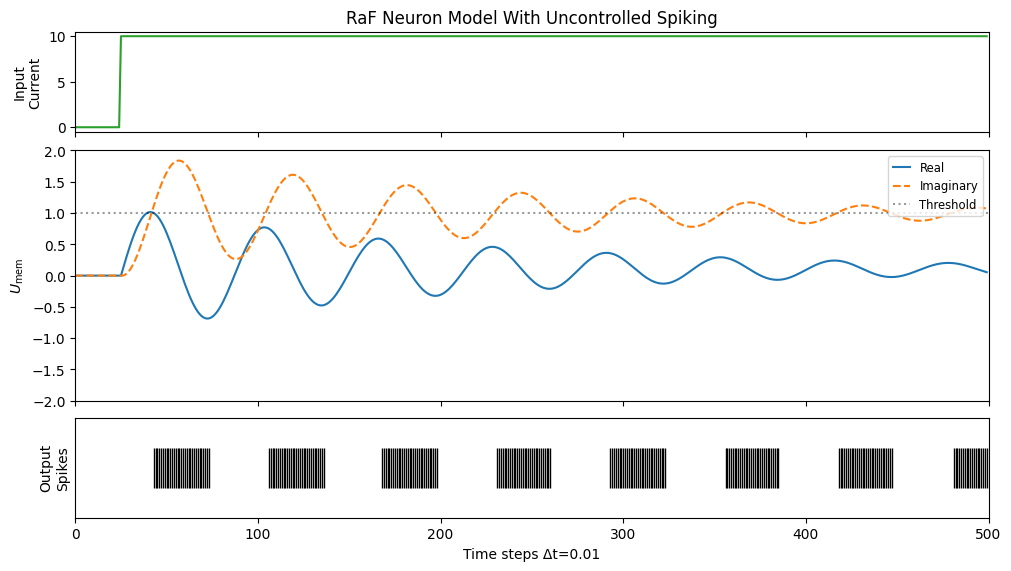

In [13]:
num_steps_ = NUM_STEPS // 2
amp_in = 10
spk_in = np.zeros(num_steps_)
spk_in[25:] = amp_in
threshold = 1
mem = (0 + 0j)
spk = False
mem_rec, spk_rec = np.zeros(num_steps_, dtype=complex), np.zeros(num_steps_, dtype=bool)

for step in range(num_steps_):
    mem_rec[step], spk_rec[step] = mem, spk
    spk, mem = resonate_and_fire(mem, spk_in[step], threshold=threshold, time_step=DT, b=1, omega=10)

first_spk = np.where(spk_rec)[0][0]
snn_plot(cur_in=spk_in, mem=mem_rec, spk_out=spk_rec, hline=threshold, vline=first_spk, 
         ylim=2, dt=DT, title="RaF Neuron Model With Uncontrolled Spiking")

### Benchmark: Complex-valued vs. Real-valued RF Models

It's worth taking a closer look at these two methods for calculating the RF neuron's membrane potential.

Both formulations describe the same oscillatory behaviour and thus give equivalent results in terms of accuracy – not to be confused with the 2nd-order integration methods (e.g. Midpoint or Runge-Kutta), which are more accurate (and elaborate) than the first-order Euler method.

However, while the real-valued formulation may be more intuitive, we stick to the complex-valued formulation in this tutorial and in the snnTorch implementation, since the use of complex numbers *in vectorised forms* (i.e. using `pytorch` tensors or `numpy` arrays) is computationally more efficient than using two real-valued variables. Also see [the PyTorch documentation on complex numbers](https://docs.pytorch.org/docs/stable/complex_numbers.html).

To showcase this difference, the cell below benchmarks the two methods for calculating the membrane potential across a PyTorch, NumPy, and (non-vectorised) pure Python implementation.
It should show the complex-valued formulation being more efficient.

In [ ]:
from timeit import timeit
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.mps.is_available() else torch.device("cpu")
batch_size, num_steps, dt, b, omega = 1000, 10_000, 0.01, 1, 10
I_val = 0.1 # constant input current

u, X_torch, Y_torch, I_torch = torch.full((batch_size,), 1.+0j, device=device), torch.ones(batch_size, device=device), torch.zeros(batch_size, device=device), torch.full((batch_size,), I_val, device=device)
U_np, X_np, Y_np, I_np = u.cpu().numpy(), X_torch.cpu().numpy(), Y_torch.cpu().numpy(), I_torch.cpu().numpy()

def calc_first_order(u_, i_):
    for _ in range(num_steps):
        u_ += dt * ((-b + 1j * omega) * u_ + i_)
    return u_
def calc_second_order(x_, y_, i_):
    for _ in range(num_steps):
        x_ += dt * (-b * x_ - omega * y_ + i_)
        y_ += dt * (omega * x_ - b * y_)
    return x_, y_
def calc_exact(u_, i_):
    for _ in range(num_steps):
        u_ = u_ * np.exp((-b + 1j * omega) * dt) + i_ * dt
    return u_
def synchronize(): # Synchronize device to ensure all operations are complete
    if device.type == 'mps':
        torch.mps.synchronize()
    elif device.type == 'cuda':
        torch.cuda.synchronize()

def run_first_order_pytorch():
    _ = calc_first_order(u.clone(), I_torch); synchronize()
def run_second_order_pytorch():
    _ = calc_second_order(X_torch.clone(), Y_torch.clone(), I_torch); synchronize()
def run_exact_pytorch():
    _ = calc_exact(u.clone(), I_torch); synchronize()

def run_first_order_numpy():
    _ = calc_first_order(U_np.copy(), I_np)
def run_second_order_numpy():
    _ = calc_second_order(X_np.copy(), Y_np.copy(), I_np)
def run_exact_numpy():
    _ = calc_exact(U_np.copy(), I_np)

def run_first_order_scalar():
    _ = calc_first_order(1.+0.j, I_val)
def run_second_order_scalar():
    _ = calc_second_order(1., 0., I_val)
def run_exact_scalar():
    _ = calc_exact(1.+0.j, I_val)

n_runs = 10
print(f"Time taken over {n_runs} runs for {num_steps} steps:\n")
def benchmark(name, fn):
    t = timeit(fn, number=n_runs)
    print(f"{name:<22} {t:.6f} s")

benchmark("PyTorch First-order:", run_first_order_pytorch)
benchmark("PyTorch Second-order:", run_second_order_pytorch)
benchmark("PyTorch Exact:", run_exact_pytorch)
print()
benchmark("NumPy First-order:", run_first_order_numpy)
benchmark("NumPy Second-order:", run_second_order_numpy)
benchmark("NumPy Exact:", run_exact_numpy)
print()
benchmark("Scalar First-order:", run_first_order_scalar)
benchmark("Scalar Second-order:", run_second_order_scalar)
benchmark("Scalar Exact:", run_exact_scalar)

Time taken over 10 runs for 10000 steps:

PyTorch First-order:   1.491706 s
PyTorch Second-order:  3.605688 s
PyTorch Exact:         1.225754 s

NumPy First-order:     0.193408 s
NumPy Second-order:    0.384121 s
NumPy Exact:           0.202728 s

Scalar First-order:    0.007886 s
Scalar Second-order:   0.006305 s
Scalar Exact:          0.035767 s


***

## 2.4 Reset Mechanisms
While the oscillatory dynamics are somewhat self-regulating, the RF neuron model still requires some form of reset mechanism to improve spiking sparsity.
Given the complex-valued membrane potential, a wider variety of reset mechanisms can be implemented – there is no clear best practice for this, though Izhikevich's reset seems most useful.  

We modify the neuron model with a few different reset mechanisms, which can be selected via the `reset` parameter.

In [14]:
def resonate_and_fire(U, I=0, time_step=DT, threshold=1, b=1, omega=10., reset='none', spike_on='imag'):
    if spike_on == 'imag':
        spk = U.imag > threshold  # check if imaginary part exceeds threshold
    else:
        spk = U.real > threshold  # check if real part exceeds threshold
    U = U + time_step * ((-b + 1j * omega) * U + I)
    
    match reset:
        case 'zero':
            U = U - spk * U  # hard reset to 0 + 0j
        case 'zero_real':
            U = U - spk * U.real  # reset real part to 0
        case 'zero_imag':
            U = U - spk * U.imag * 1j  # reset imaginary part to 0  
        case 'izhikevich':
            U = U - spk * (U - 1j * threshold)  # reset to 0 + 1j * threshold
        case 'izhikevich_real':
            U = U - spk * (U - threshold)  # reset to threshold + 0j
        # Use of np.sign() ensures subtraction towards 0
        case 'subtract':
            U = U - spk * np.sign(U) * threshold  # subtracts the threshold from the *magnitude*
        case 'subtract_real':
            U = U - spk * np.sign(U.real) * threshold  # subtract the threshold from real part only
        case 'subtract_imag':
            U = U - spk * 1j * np.sign(U.imag) * threshold  # subtract the threshold from imaginary part only
        case 'none':
            pass  # do nothing, keep U as is
    return spk, U

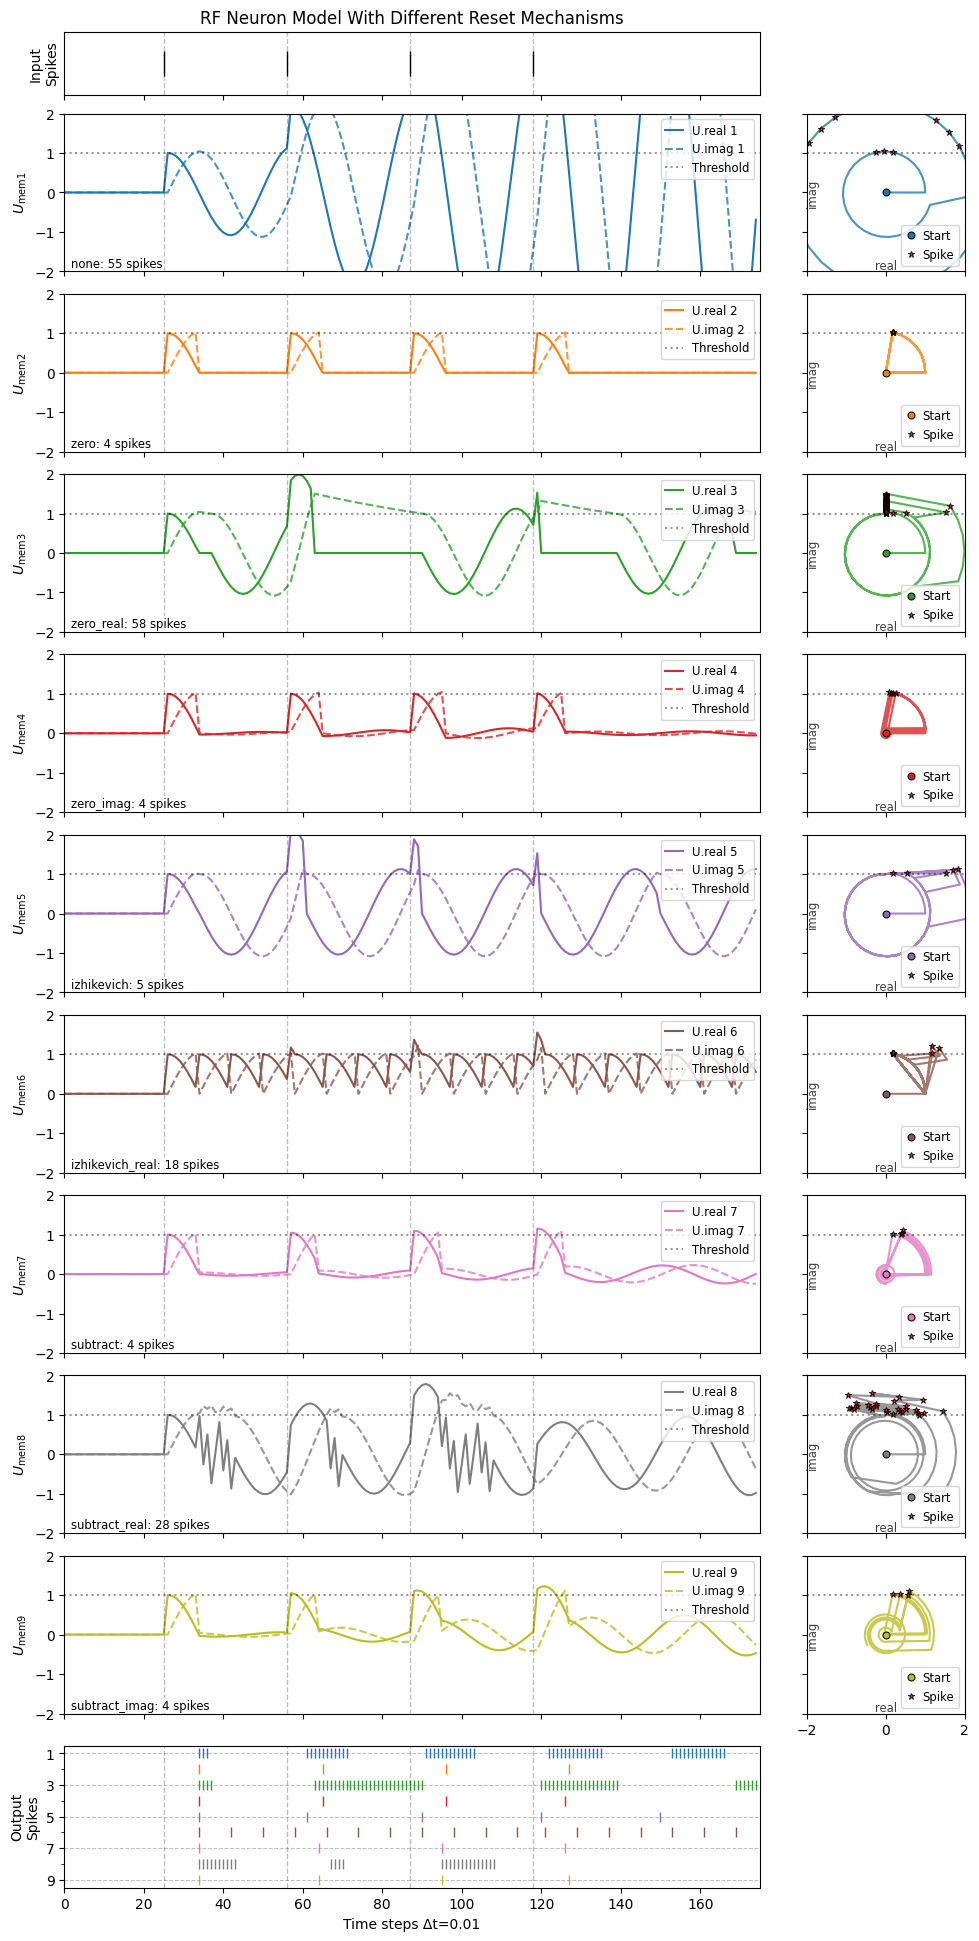

In [ ]:
num_steps_ = 175
amp_in = 100
b, omega = 1.5, 20
spk_in = generate_resonant_spikes(num_steps_, first_spike=25, omega=omega, amplitude=amp_in, n_spikes=4, dt=DT, add_neg_spike=False)
# Test all reset types available
reset_types = ['none', 'zero', 'zero_real', 'zero_imag', 'izhikevich', 'izhikevich_real', 'subtract', 'subtract_real', 'subtract_imag']

n_resets = len(reset_types)
mem_vars = [(0 + 0j) for _ in range(n_resets)]
spk_vars = [False for _ in range(n_resets)]
mem_recs = [np.zeros(num_steps_, dtype=complex) for _ in range(n_resets)]
spk_recs = [np.zeros(num_steps_, dtype=bool) for _ in range(n_resets)]

for step in range(num_steps_):
    for i in range(n_resets):
        mem_recs[i][step] = mem_vars[i]
        spk_recs[i][step] = spk_vars[i]
    for i, reset_type in enumerate(reset_types):
        spk_vars[i], mem_vars[i] = resonate_and_fire(
            mem_vars[i], spk_in[step], b=b, omega=omega, reset=reset_type, spike_on='imag')

spike_counts = [spk_rec.sum() for spk_rec in spk_recs]
snn_plot(spk_in=spk_in, mem=mem_recs, spk_out=spk_recs, hline=threshold,
         ylim=2, fig_size=(10, 9), vline=spk_in.nonzero()[0], dt=DT,
         title="RF Neuron Model With Different Reset Mechanisms",
         mem_labels=[r + f": {count} spikes" for r, count in zip(reset_types, spike_counts)], phase_portrait=True)

In [19]:
a = plot_phase_portrait(mem_recs, spk_recs,
                    xylim=2, thrline=threshold, animate=True, dt=DT, animate_speed=.5,
                    mem_labels=reset_types)
HTML(a.to_html5_video())

## 2.5 Refractory Mechanisms
While reset mechanisms work well with integrator neurons, they are not as effective for resonators since they can disrupt the oscillatory behaviour of the membrane potential.  
To address this, a **refractory period** can be used instead of (or in addition to) a reset mechanism.  
This means that after a spike, the neuron is temporarily unable to spike again, which allows the oscillatory behaviour to continue without interruption.

Not as easily implemented, hence it remains future work for now.

# Conclusion

That covers the basic resonate-and-fire neuron model and how it functions, but in practice, we wouldn't use it for training a neural network.
There's too many hyperparameters to tune, as well as the numerical error introduced by the discretisation that needs to be dealt with.

So in the 2nd tutorial, we will eliminate most of these hyperparameters, reduce the numerical error, and introduce a simplified RF neuron that is better suited for large-scale deep learning.

## Further Reading
* [*Resonate-and-fire neurons* (2001)](https://www.izhikevich.org/publications/resfire.pdf) by Eugene M. Izhikevich
* [*Dynamical Systems in Neuroscience* (2007)](https://www.izhikevich.org/publications/dsn.pdf) by Eugene M. Izhikevich